In [37]:
import pandas as pd
import numpy as np

orcs = pd.read_csv('orcs_cleaned.csv', index_col=0, encoding='utf-8')
orcs.family = orcs.family.astype('int')
        
orcs.mil_rank_cl.unique()

array(['Солдаты, матросы, сержанты, старшины', 'Прапорщики и мичманы',
       'младшие офицеры', 'старшие офицеры', 'высшие офицеры'],
      dtype=object)

<AxesSubplot:>

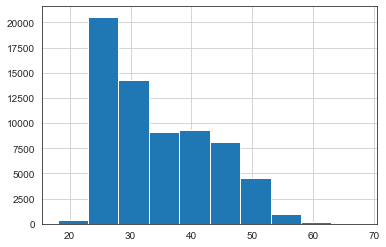

In [38]:
orcs.age.hist()

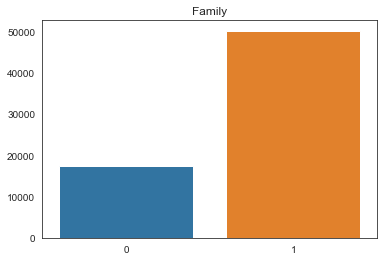

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')
ax = sns.countplot(x='family', data=orcs).set_title('Family')
ax.axes.set_xlabel('')
ax.axes.set_ylabel('')
plt.show()

In [40]:
targets = orcs.mil_rank_cl
features = orcs.drop(['mil_rank_cl', 'age'], axis=1)
features = pd.get_dummies(features)
features

,family,nationality_аварец,nationality_азербайджанец,nationality_армянин,nationality_башкир,nationality_бурят,nationality_бурят,nationality_даргинец,nationality_кабардинец,nationality_казах,...,age_range_21-25,age_range_26-30,age_range_31-35,age_range_36-40,age_range_41-45,age_range_46-50,age_range_51-55,age_range_56-60,age_range_61-65,age_range_66-70
orc_id,,,,,,,,,,,,,,,,,,,,,
2,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110825,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
110826,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
110828,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [41]:
from sklearn.preprocessing import StandardScaler

features = StandardScaler().fit_transform(features)
features.shape

(67443, 123)

In [42]:
from sklearn.preprocessing import LabelEncoder

targets = LabelEncoder().fit_transform(targets)   
targets

array([1, 1, 1, ..., 0, 1, 1])

In [43]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(features, targets, random_state=50)

In [44]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier


dict_classifiers = {
        
    "Nearest Neighbors": 
            {
              'classifier': KNeighborsClassifier(),
              'name': 'KNN',
              'params': [
                          {
                              'n_neighbors': [5, 10, 20],
                              'leaf_size': [3, 30]
                          }
                        ] 
            },

    "Decision Tree":
            {
                'classifier': DecisionTreeClassifier(),
                'name': 'DT',
                'params': [
                            {
                                'max_depth': [10, 20, 30, None],
                                'criterion': ['gini', 'entropy'],
                                'splitter': ['best', 'random'],
                                'min_samples_split': [2, 5, 10],
                                'min_samples_leaf': [1, 2, 5]
                            }
                          ] 
            },
            
    "Random Forest": 
            {
                'classifier': RandomForestClassifier(),
                'name': 'RF',
                'params': [
                            {
                                'max_depth': [10, 50, 100],
                                'min_samples_leaf': [10, 50, 100],
                                'n_estimators': [50, 100, 200]
                            }
                          ]
            },

    "Naive Bayes": 
            {
                'classifier': GaussianNB(),
                'name': 'NB',
                'params': [
                            {
                                'var_smoothing': np.logspace(0, -9, 10)
                            }
                          ]                
            },
            
    "Logistic Regression":
            {
                'classifier': LogisticRegression(),
                'name': 'LR',
                'params': [
                            {
                                "C": np.logspace(-3, 3, 5), 
                                "penalty": ["l1", "l2"] 
                                # l1 lasso l2 ridge
                            }
                          ]                
            },
            
    "Multilayer Perceptron":
            {
                'classifier': MLPClassifier(),
                'name': 'MLP',
                'params': [
                            {
                                'hidden_layer_sizes': [(50, 50, 50), 
                                                       (50, 100, 50), 
                                                       (100,)]
                            }
                          ]                
            },
            
    "Gradient Boosting":
            {
                'classifier': GradientBoostingClassifier(),
                'name': 'GB',
                'params': [
                            {
                                
                            }
                          ]                
            }
}

In [45]:
from sklearn.model_selection import learning_curve 


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1):
    """
        Generate a simple plot of the test and traning learning curve.

        Parameters
        ----------
        estimator : object type that implements the "fit" and "predict" methods
            An object of that type which is cloned for each validation.

        title : string
            Title for the chart.

        X : array-like, shape (n_samples, n_features)
            Training vector, where n_samples is the number of samples and
            n_features is the number of features.

        y : array-like, shape (n_samples) or (n_samples, n_features), optional
            Target relative to X for classification or regression;
            None for unsupervised learning.

        ylim : tuple, shape (ymin, ymax), optional
            Defines minimum and maximum yvalues plotted.

        cv : integer, cross-validation generator, optional
            If an integer is passed, it is the number of folds (defaults to 3).
            Specific cross-validation objects can be passed, see
            sklearn.cross_validation module for the list of possible objects

        n_jobs : integer, optional
            Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
        
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, 
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [46]:
import time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pickle


num_classifiers = len(dict_classifiers.keys())

def batch_classify(X_train, Y_train, X_test, Y_test, classifier, verbose=True):
    """
        Classify the data using the given classifier

        Args:
            X_train (_type_): Training data
            Y_train (_type_): Training labels
            X_test (_type_): Test data
            Y_test (_type_): Test labels
            classifier (_type_): Classifier to use
            verbose (bool, optional): Print progress to stdout. Defaults to True.

        Returns: (_type_): Classifier score        
    """
    results = pd.Series()

    t_start = time.perf_counter()
    grid = GridSearchCV(dict_classifiers[classifier]['classifier'], 
                        dict_classifiers[classifier]['params'], 
                        cv=3, n_jobs=3, verbose=verbose, refit=True)     
                                 
    estimator = grid.fit(X_train, Y_train)
    t_diff = time.perf_counter() - t_start
    
    filename = f'models/{dict_classifiers[classifier]["name"]}.sav'
    pickle.dump(estimator, open(filename, 'wb'))    
    
    train_score = estimator.score(X_train, Y_train)
    test_score = estimator.score(X_test, Y_test)
    
    predicted = estimator.predict(x_test)
    expected = y_test

    confusion = confusion_matrix(expected, predicted)
    print(confusion, end="\n\n")
    
    names = [str(i) for i in orcs.mil_rank_cl.unique()]
    print(classification_report(expected, predicted, target_names=names), end="\n\n")
    # Accuracy - number of correct predictions over all predictions
    # Precision - how many of the positive predictions made are correct (true positives)
    # Recall - how many of the positive cases the classifier correctly predicted, 
    #          over all the positive cases in the data
    # F1 - harmonic mean of precision and recall
    
    results.loc[0] = classifier
    results.loc[1] = train_score
    results.loc[2] = test_score
    results.loc[3] = t_diff
    
    if verbose:
        print("Trained {c} in {f:.2f} s".format(c=classifier, f=t_diff))
    
    plot_learning_curve(estimator, "{}".format(classifier), X_train, Y_train, cv=3, n_jobs=3)
        
    return results

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[[  201   880     0    39   775]
 [  150 10971     0    58   710]
 [    4     0     0     0     8]
 [   55   851     0    60   445]
 [  145   416     0    32  1061]]

                                      precision    recall  f1-score   support

Солдаты, матросы, сержанты, старшины       0.36      0.11      0.16      1895
                Прапорщики и мичманы       0.84      0.92      0.88     11889
                     младшие офицеры       0.00      0.00      0.00        12
                     старшие офицеры       0.32      0.04      0.08      1411
                      высшие офицеры       0.35      0.64      0.46      1654

                            accuracy                           0.73     16861
                           macro avg       0.37      0.34      0.31     16861
                        weighted avg       0.69      0.73      0.69     16861


Trained Decision Tree in 123.09 s


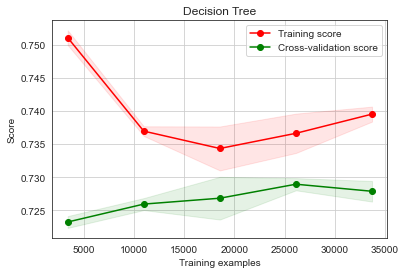

In [47]:
import warnings

warnings.filterwarnings("ignore")

df_results = pd.DataFrame(np.zeros(shape=(0, 4)), 
                          columns = ['classifier', 'train_score', 'test_score', 'training_time'])

dt = batch_classify(x_train, y_train, x_test, y_test, 'Decision Tree')

df_results = df_results.append({'classifier': dt[0], 'train_score': dt[1], 
                                'test_score': dt[2], 'training_time': dt[3]}, 
                                ignore_index=True)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[[  507  1049     0    48   291]
 [  383 11140     0    60   306]
 [    5     4     0     0     3]
 [  139   977     0    67   228]
 [  480   641     0    34   499]]

                                      precision    recall  f1-score   support

Солдаты, матросы, сержанты, старшины       0.33      0.27      0.30      1895
                Прапорщики и мичманы       0.81      0.94      0.87     11889
                     младшие офицеры       0.00      0.00      0.00        12
                     старшие офицеры       0.32      0.05      0.08      1411
                      высшие офицеры       0.38      0.30      0.33      1654

                            accuracy                           0.72     16861
                           macro avg       0.37      0.31      0.32     16861
                        weighted avg       0.67      0.72      0.68     16861


Trained Nearest Neighbors in 121.81 s


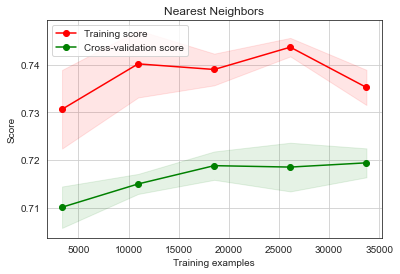

In [48]:
warnings.filterwarnings("ignore")

knn = batch_classify(x_train, y_train, x_test, y_test, 'Nearest Neighbors')

df_results = df_results.append({'classifier': knn[0], 'train_score': knn[1], 
                                'test_score': knn[2], 'training_time': knn[3]}, 
                                ignore_index=True)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[[ 245 1157  419   22   52]
 [ 578 9646 1344   82  239]
 [   2    2    7    0    1]
 [ 152  916  200   64   79]
 [ 276  839  379   41  119]]

                                      precision    recall  f1-score   support

Солдаты, матросы, сержанты, старшины       0.20      0.13      0.16      1895
                Прапорщики и мичманы       0.77      0.81      0.79     11889
                     младшие офицеры       0.00      0.58      0.01        12
                     старшие офицеры       0.31      0.05      0.08      1411
                      высшие офицеры       0.24      0.07      0.11      1654

                            accuracy                           0.60     16861
                           macro avg       0.30      0.33      0.23     16861
                        weighted avg       0.61      0.60      0.59     16861


Trained Naive Bayes in 3.62 s


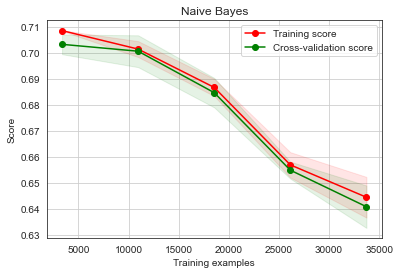

In [49]:
warnings.filterwarnings("ignore")

nb = batch_classify(x_train, y_train, x_test, y_test, 'Naive Bayes')

df_results = df_results.append({'classifier': nb[0], 'train_score': nb[1], 
                                'test_score': nb[2], 'training_time': nb[3]}, 
                                ignore_index=True)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[[  342  1107     0    32   414]
 [  221 11165     0    93   410]
 [    4     0     1     0     7]
 [  104   969     0    53   285]
 [  312   620     0    43   679]]

                                      precision    recall  f1-score   support

Солдаты, матросы, сержанты, старшины       0.35      0.18      0.24      1895
                Прапорщики и мичманы       0.81      0.94      0.87     11889
                     младшие офицеры       1.00      0.08      0.15        12
                     старшие офицеры       0.24      0.04      0.06      1411
                      высшие офицеры       0.38      0.41      0.39      1654

                            accuracy                           0.73     16861
                           macro avg       0.55      0.33      0.34     16861
                        weighted avg       0.66      0.73      0.68     16861


Trained Logistic Regression in 19.66 s


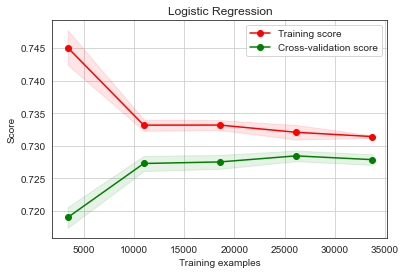

In [50]:
warnings.filterwarnings("ignore")

lr = batch_classify(x_train, y_train, x_test, y_test, 'Logistic Regression')

df_results = df_results.append({'classifier': lr[0], 'train_score': lr[1], 
                                'test_score': lr[2], 'training_time': lr[3]}, 
                                ignore_index=True)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[[  370   895     0     4   626]
 [  254 10995     0    12   628]
 [    3     0     1     0     8]
 [  108   885     0    14   404]
 [  343   410     0    10   891]]

                                      precision    recall  f1-score   support

Солдаты, матросы, сержанты, старшины       0.34      0.20      0.25      1895
                Прапорщики и мичманы       0.83      0.92      0.88     11889
                     младшие офицеры       1.00      0.08      0.15        12
                     старшие офицеры       0.35      0.01      0.02      1411
                      высшие офицеры       0.35      0.54      0.42      1654

                            accuracy                           0.73     16861
                           macro avg       0.58      0.35      0.34     16861
                        weighted avg       0.69      0.73      0.69     16861


Trained Gradient Boosting in 233.62 s


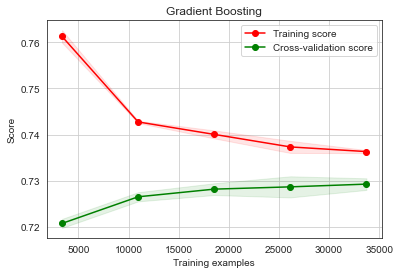

In [51]:
warnings.filterwarnings("ignore")

gbc = batch_classify(x_train, y_train, x_test, y_test, 'Gradient Boosting')

df_results = df_results.append({'classifier': gbc[0], 'train_score': gbc[1], 
                                'test_score': gbc[2], 'training_time': gbc[3]}, 
                                ignore_index=True)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[[  251  1140     0    31   473]
 [  187 11250     0    37   415]
 [    4     1     0     0     7]
 [   68  1009     0    40   294]
 [  232   651     0    20   751]]

                                      precision    recall  f1-score   support

Солдаты, матросы, сержанты, старшины       0.34      0.13      0.19      1895
                Прапорщики и мичманы       0.80      0.95      0.87     11889
                     младшие офицеры       0.00      0.00      0.00        12
                     старшие офицеры       0.31      0.03      0.05      1411
                      высшие офицеры       0.39      0.45      0.42      1654

                            accuracy                           0.73     16861
                           macro avg       0.37      0.31      0.31     16861
                        weighted avg       0.67      0.73      0.68     16861


Trained Random Forest in 184.59 s


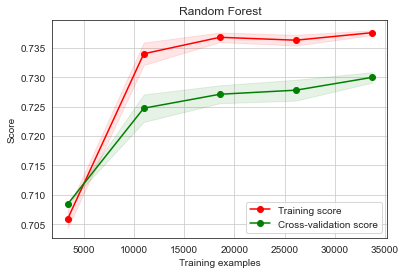

In [52]:
warnings.filterwarnings("ignore")

rf = batch_classify(x_train, y_train, x_test, y_test, 'Random Forest')

df_results = df_results.append({'classifier': rf[0], 'train_score': rf[1], 
                                'test_score': rf[2], 'training_time': rf[3]}, 
                                ignore_index=True)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[[  408   945     0    42   500]
 [  289 11013     0    71   516]
 [    2     1     1     0     8]
 [  117   863     0    74   357]
 [  379   465     2    39   769]]

                                      precision    recall  f1-score   support

Солдаты, матросы, сержанты, старшины       0.34      0.22      0.26      1895
                Прапорщики и мичманы       0.83      0.93      0.87     11889
                     младшие офицеры       0.33      0.08      0.13        12
                     старшие офицеры       0.33      0.05      0.09      1411
                      высшие офицеры       0.36      0.46      0.40      1654

                            accuracy                           0.73     16861
                           macro avg       0.44      0.35      0.35     16861
                        weighted avg       0.69      0.73      0.69     16861


Trained Multilayer Perceptron in 332.55 s


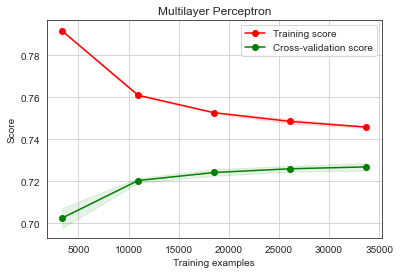

In [53]:
warnings.filterwarnings("ignore")

mlp = batch_classify(x_train, y_train, x_test, y_test, 'Multilayer Perceptron')

df_results = df_results.append({'classifier': mlp[0], 'train_score': mlp[1], 
                                'test_score': mlp[2], 'training_time': mlp[3]}, 
                                ignore_index=True)

In [54]:
df_results = df_results.sort_values(by=['test_score'], ascending=False)
df_results

,classifier,train_score,test_score,training_time
0,Decision Tree,0.737436,0.729079,123.094413
5,Random Forest,0.736863,0.729020,184.586649
4,Gradient Boosting,0.734965,0.727774,233.618126
6,Multilayer Perceptron,0.743328,0.727418,332.547546
3,Logistic Regression,0.731051,0.725936,19.659188
1,Nearest Neighbors,0.748231,0.724334,121.808951
2,Naive Bayes,0.603021,0.597889,3.622630
